# Deploy Stable Diffusion on a SageMaker GPU Single Model Endpoint with Triton

In this notebook we will host Stable Diffusion  SageMaker GPU Multi-Model Endpoints (MME GPU) powered by NVIDIA Triton Inference Server.

Skip to:
1. [Installs and imports](#installs)
2. [Save a pretrained model](#modelartifact)
3. [Packaging a conda environment, extending Sagemaker Triton container](#condaenv)
4. [Local testing of Triton model repository](#local)
5. [Deploy to SageMaker Real-Time Endpoint](#deploy)
6. [Analyze endpoint logs](#logs)
7. [Clean up](#cleanup)
------
------

### Part 1 - Installs and imports <a name="installs"></a>

In [1]:
!pip install nvidia-pyindex
!pip install tritonclient[http]
!pip install -U sagemaker ipywidgets pillow numpy transformers accelerate diffusers

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Preparing metadata (setup.py) ... done
  Created wheel for nvidia-pyindex: filename=nvidia_pyindex-1.0.9-py3-none-any.whl size=8418 sha256=149f25543fe93332f3642f3b88c06e3565aa4aed23f8790d641a38de9c71b37d
  Stored in directory: /home/ec2-user/.cache/pip/wheels/0e/62/68/8bb6aafc3cb47e3468055aebc10d004b55da43563d748aac9c
Successfully built nvidia-pyindex
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 195.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 257.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 kB 357.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.2/357.2 kB 405.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com, https://pypi.ngc.nvidia.com
  

In [2]:
import boto3
import sagemaker
from sagemaker import get_execution_role

import tritonclient.http as httpclient
from tritonclient.utils import *
import time
from PIL import Image
import numpy as np

# variables
s3_client = boto3.client("s3")
ts = time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

# sagemaker variables
role = get_execution_role()
sm_client = boto3.client(service_name="sagemaker")
runtime_sm_client = boto3.client("sagemaker-runtime")
sagemaker_session = sagemaker.Session(boto_session=boto3.Session())
bucket = sagemaker_session.default_bucket()

### Part 2 - Save pretrained model <a name="modelartifact"></a>

We save a pretrained Stable Diffusion Model to the Triton model repository directory.

In [3]:
import diffusers
import torch 

pipeline = diffusers.StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4",
                                                             cache_dir='hf_cache',
                                                             torch_dtype=torch.float16,
                                                             revision="fp16")

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [4]:
pipeline.save_pretrained('model_repo_0/pipeline_0/stable_diff')

### Part 3 - Packaging a conda environment, extending Sagemaker Triton container <a name="condaenv"></a>

When using the Triton Python backend (which our Stable Diffusion model will run on), you can include your own environment and dependencies. The recommended way to do this is to use [conda pack](https://conda.github.io/conda-pack/) to generate a conda environment archive in `tar.gz` format, and point to it in the `config.pbtxt` file of the models that should use it, adding the snippet: 

```
parameters: {
  key: "EXECUTION_ENV_PATH",
  value: {string_value: "path_to_your_env.tar.gz"}
}

```
You can use a different environment per model, or the same for all models (read more on this [here](https://github.com/triton-inference-server/python_backend#creating-custom-execution-environments)). Since we are hosting many versions of the same model, only perhaps personalized (fine-tuned) for different end-users, we don't want the overhead of including a different environment for each one, which would also increase the model S3 download and GPU load times. 

Therefore, we will create the packaged environment once, and include it directly in our container image, where all hosted models can access it. In order to do this, we will extend the public SageMaker Triton container image. 

Let's start by creating the conda environment with the necessary dependencies; this script will output a `stablediff_env.tar.gz` file.

In [5]:
!cd docker && bash conda_dependencies.sh 

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 22.9.0
  latest version: 23.1.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/stablediff_env

  added / updated specs:
    - python=3.8


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-3.1.0              |       h0b41bf4_0         2.5 MB  conda-forge
    pip-23.0.1                 |     pyhd8ed1ab_0         1.3 MB  conda-forge
    python-3.8.16              |he550d4f_1_cpython        21.8 MB  conda-forge
    setuptools-67.6.0          |     pyhd8ed1ab_0         566 KB  conda-forge
    wheel-0.40.0               |     pyhd8ed1ab_0          54 KB  conda-forge
    ------------------------------------------------------------
                                           Total:    

Now, we get the correct URI for the SageMaker Triton container image. Check out all the available Deep Learning Container images that AWS maintains [here](https://github.com/aws/deep-learning-containers/blob/master/available_images.md). 

In [15]:
# account mapping for SageMaker Triton Image
account_id_map = {
    "us-east-1": "785573368785",
    "us-east-2": "007439368137",
    "us-west-1": "710691900526",
    "us-west-2": "301217895009",
    "eu-west-1": "802834080501",
    "eu-west-2": "205493899709",
    "eu-west-3": "254080097072",
    "eu-north-1": "601324751636",
    "eu-south-1": "966458181534",
    "eu-central-1": "746233611703",
    "ap-east-1": "110948597952",
    "ap-south-1": "763008648453",
    "ap-northeast-1": "941853720454",
    "ap-northeast-2": "151534178276",
    "ap-southeast-1": "324986816169",
    "ap-southeast-2": "355873309152",
    "cn-northwest-1": "474822919863",
    "cn-north-1": "472730292857",
    "sa-east-1": "756306329178",
    "ca-central-1": "464438896020",
    "me-south-1": "836785723513",
    "af-south-1": "774647643957",
}



region = boto3.Session().region_name
if region not in account_id_map.keys():
    raise ("UNSUPPORTED REGION")

base = "amazonaws.com.cn" if region.startswith("cn-") else "amazonaws.com"


triton_image_uri = (
    "{account_id}.dkr.ecr.{region}.{base}/sagemaker-tritonserver:22.12-py3".format(
        account_id=account_id_map[region], region=region, base=base
    )
)

print(triton_image_uri)

785573368785.dkr.ecr.us-east-1.amazonaws.com/sagemaker-tritonserver:22.12-py3


In [21]:
print(region)

us-east-1


We then build our extended image, which does nothing more than to copy the packaged environment into the container. Let's check out the Dockerfile.

In [16]:
!cat docker/Dockerfile

ARG BASE_IMAGE

FROM $BASE_IMAGE

#Install any additional libraries
RUN echo "Adding conda package to Docker image"
RUN mkdir -p /home/condpackenv/

# Copy conda env
COPY stablediff_env.tar.gz /home/condpackenv/stablediff_env.tar.gz

In [18]:
# Change this var to change the name of new container image
new_image_name = 'sagemaker-tritonserver-byoc'

We catch the docker build process' output so that we can easily capture the output container image URI, and check for build errors.

In [22]:
%%capture build_output
!cd docker && bash build_and_push.sh "$new_image_name" 22.12 "$triton_image_uri" "$region"

In [23]:
if 'Error response from daemon' in str(build_output):
    print(build_output)
    raise SystemExit('\n\n!!There was an error with the container build!!')
else:
    extended_triton_image_uri = str(build_output).strip().split('\n')[-1]

If the previous cell failed, check the docker build logs to understand the error problem, and read the possible resolution in the next cell

In [11]:
"""
If the cell above fails (check out the build_output) because of missing permissions to pull the public Triton base container image,
uncomment the commands in this cell, run them and retry the build
"""
mapped_region_account = account_id_map[region]
!aws ecr get-login-password --region "$region" | docker login --username AWS --password-stdin "$mapped_region_account".dkr.ecr."$region".amazonaws.com

WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded


----
----

### Part 4 - Local testing of Triton model repository <a name="local"></a>

Now you can test the model repository and validate it is working. Let's run the Triton docker container locally and invoke the model to check this.

In [ ]:
repo_name = "model_repo_0"

We are running the Triton container in detached model with the `-d` flag so that it runs in the background. 

In [ ]:
!docker run --gpus=all -d --shm-size=4G --rm -p8000:8000 -p8001:8001 -p8002:8002 -v$(pwd)/$repo_name:/model_repository $extended_triton_image_uri tritonserver --model-repository=/model_repository --exit-on-error=false
time.sleep(90)

In [ ]:
CONTAINER_ID=!docker container ls -q
FIRST_CONTAINER_ID = CONTAINER_ID[0]

In [ ]:
!echo $FIRST_CONTAINER_ID

In [ ]:
!docker logs $FIRST_CONTAINER_ID

<div class="alert alert-warning">
<b>Warning</b>: Rerun the cell above to check the container logs until you verify that Triton has loaded all models successfully, otherwise inference request will fail.
</div>

#### Now we will invoke the script locally

We will use Triton's HTTP client and its utility functions to send a request to `localhost:8000`, where the server is listening. We are sending text as binary data for input and receiving an array that we decode with numpy as output. Check out the code in `model_repository/pipeline/1/model.py` to understand how the input data is decoded and the output data returned, and check out more Triton Python backend [docs](https://github.com/triton-inference-server/python_backend) and [examples](https://github.com/triton-inference-server/python_backend/tree/main/examples) to understand how to handle other data types.

In [ ]:
client = httpclient.InferenceServerClient(url="localhost:8000")

prompt = "Pikachu in a detective trench coat, photorealistic, nikon"
text_obj = np.array([prompt], dtype="object").reshape((-1, 1))

input_text = httpclient.InferInput("prompt", text_obj.shape, np_to_triton_dtype(text_obj.dtype))

input_text.set_data_from_numpy(text_obj)

output_img = httpclient.InferRequestedOutput("generated_image")

start = time.time()
query_response = client.infer(model_name="pipeline_0", inputs=[input_text], outputs=[output_img])
print(f"took {time.time()-start} seconds")

image = query_response.as_numpy("generated_image")
im = Image.fromarray(np.squeeze(image))
im.save("generated_image.jpg")

In [ ]:
display(im)

Let's stop the container that is running locally so we don't take up notebook resources.

In [ ]:
!docker kill $FIRST_CONTAINER_ID

----
----
### Part 5 - Deploy to SageMaker Real-Time Endpoint <a name="deploy"></a>

SageMaker expects a .tar.gz file containing each Triton model repository to be hosted on the multi-model endpoint. To simulate several similar models being hosted, you might think all it takes is to tar the model repository we have already built, and then copy it with different file names. However, Triton does not at this point allow for non-unique model names. Therefore, we will first copy our model repo `N` times, changing the model directory names and their corresponding config.pbtxt files.

<div class="alert alert-warning">
<b>Warning</b>: In this example, we are using many copies of the same model to simulate a situation where different personalized (fine-tuned) instances of the same architecture need be served, and because it is easy to demonstrate; however, you can place a different model and inference script in each tar.gz file.
</div>

In [24]:
!rm -rf `find -type d -name .ipynb_checkpoints`

In [35]:
import os
import shutil

N = 1
prefix = 'stable-diffusion-byoc'
model_repo_base = 'model_repo'

# Get model names from model_repo_0
model_names = [name for name in os.listdir(f'{model_repo_base}_0') if os.path.isdir(f'{model_repo_base}_0/{name}')]

for i in range(N):
    # Make copy of previous model repo, increment # id
    shutil.copytree(f'{model_repo_base}_0', f'{model_repo_base}_{i+1}')
    time.sleep(5)
    for name in model_names:
        model_dirs_path = f'{model_repo_base}_{i+1}/{name}'

        # Open each model's config file to increment model # id there 
        fin = open(f'{model_dirs_path}/config.pbtxt', "rt")
        data = fin.read()
        data = data.replace(name, name[:-1] + str(i+1))
        fin.close()
        fin = open(f'{model_dirs_path}/config.pbtxt', "wt")
        fin.write(data)
        fin.close()
    
        # Change model directory name to match new config
        os.rename(model_dirs_path,model_dirs_path[:-1]+str(i+1))
        time.sleep(2)
        
    if i == :
        tar_file_name = f'stable-diff-{i}.tar.gz'
        model_repo_target = f'{model_repo_base}_{i}/'
        !tar -C $model_repo_target -czf $tar_file_name .
        sagemaker_session.upload_data(path=tar_file_name, key_prefix=prefix)

    tar_file_name = f'stable-diff-{i+1}.tar.gz'
    model_repo_target = f'{model_repo_base}_{i+1}/'
    !tar -C $model_repo_target -czf $tar_file_name .
    sagemaker_session.upload_data(path=tar_file_name, key_prefix=prefix)
    !sudo rm -r "$tar_file_name" "$model_repo_target"

In [39]:
!pwd

/home/ec2-user/SageMaker/sagemaker-mme-examples-main-GenerativeAI-stable_diffusion-hf_pipeline/GenerativeAI/stable_diffusion/hf_pipeline


In [40]:
sagemaker_session.upload_data(path="model.tar.gz", key_prefix=prefix)

's3://sagemaker-us-east-1-757967535041/stable-diffusion-byoc/model.tar.gz'

Create SM container and model definitions.

In [46]:
model_data_url = f"s3://{bucket}/{prefix}/model.tar.gz"
ts = time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

container = {
    "Image": extended_triton_image_uri,
    # "Image": triton_image_uri,
    "ModelDataUrl": model_data_url,
}
print(model_data_url)
print(container)

s3://sagemaker-us-east-1-757967535041/stable-diffusion-byoc/model.tar.gz
{'Image': '757967535041.dkr.ecr.us-east-1.amazonaws.com/sagemaker-tritonserver-byoc:22.12', 'ModelDataUrl': 's3://sagemaker-us-east-1-757967535041/stable-diffusion-byoc/model.tar.gz'}


In [47]:
sm_model_name = f"{prefix}-{ts}"
print(sm_model_name)

create_model_response = sm_client.create_model(
    ModelName=sm_model_name, ExecutionRoleArn=role, PrimaryContainer=container
)

print("Model Arn: " + create_model_response["ModelArn"])

stable-diffusion-byoc-2023-03-22-01-13-52
Model Arn: arn:aws:sagemaker:us-east-1:757967535041:model/stable-diffusion-byoc-2023-03-22-01-13-52


Create a SageMaker endpoint configuration.

In [48]:
endpoint_config_name = f"{prefix}-epc-{ts}"

instance_type = 'ml.p4d.24xlarge'

create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "InstanceType": instance_type,
            "InitialVariantWeight": 1,
            "InitialInstanceCount": 1,
            "ModelName": sm_model_name,
            "VariantName": "AllTraffic",
        }
    ],
)

print("Endpoint Config Arn: " + create_endpoint_config_response["EndpointConfigArn"])

Endpoint Config Arn: arn:aws:sagemaker:us-east-1:757967535041:endpoint-config/stable-diffusion-byoc-epc-2023-03-22-01-13-52


Create the endpoint, and wait for it to be up and running.

In [50]:
endpoint_name = f"{prefix}-ep-{ts}"

create_endpoint_response = sm_client.create_endpoint(
    EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name
)

print("Endpoint Arn: " + create_endpoint_response["EndpointArn"])

Endpoint Arn: arn:aws:sagemaker:us-east-1:757967535041:endpoint/stable-diffusion-byoc-ep-2023-03-22-01-13-52


In [51]:
resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
status = resp["EndpointStatus"]
print("Status: " + status)

while status == "Creating":
    time.sleep(60)
    resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
    status = resp["EndpointStatus"]
    print("Status: " + status)

print("Arn: " + resp["EndpointArn"])
print("Status: " + status)

Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: InService
Arn: arn:aws:sagemaker:us-east-1:757967535041:endpoint/stable-diffusion-byoc-ep-2023-03-22-01-13-52
Status: InService


#### Invoke models

In [52]:
prompt = "Smiling person"
inputs = []
outputs = []

text_obj = np.array([prompt], dtype="object").reshape((-1, 1))

inputs.append(httpclient.InferInput("prompt", text_obj.shape, np_to_triton_dtype(text_obj.dtype)))
inputs[0].set_data_from_numpy(text_obj)


outputs.append(httpclient.InferRequestedOutput("generated_image"))

Since we are using the SageMaker Runtime client to send an HTTP request to the endpoint now, we use Triton's `generate_request_body` method to create the right [request format](https://github.com/triton-inference-server/server/tree/main/docs/protocol) for us.

In [53]:
request_body, header_length = httpclient.InferenceServerClient.generate_request_body(
    inputs, outputs=outputs
)

print(request_body)

b'{"inputs":[{"name":"prompt","shape":[1,1],"datatype":"BYTES","parameters":{"binary_data_size":18}}],"outputs":[{"name":"generated_image","parameters":{"binary_data":true}}]}\x0e\x00\x00\x00Smiling person'


We are sending our request in binary format for lower inference latency. We'll invoke each model 3 times, so we can verify that inference latency is only higher on the first request, when the model needs to be loaded.

With the binary+json format, we have to specify the length of the request metadata in the header to allow Triton to correctly parse the binary payload. This is done using a custom Content-Type header, which is different from using an `Inference-Header-Content-Length` header on a standalone Triton server because custom headers arenât allowed in SageMaker. 

In [54]:
header_length_prefix = "application/vnd.sagemaker-triton.binary+json;json-header-size="

image_list = []
for j in range(N):
    for k in range(3):
        tick = time.time()
        # Invoke model j
        response = runtime_sm_client.invoke_endpoint(
            EndpointName=endpoint_name,
            ContentType="application/vnd.sagemaker-triton.binary+json;json-header-size={}".format(header_length),
            Body=request_body,
#             TargetModel=f'stable-diff-{j}.tar.gz'
        )
        tock =time.time()
        print(f'Finished model {j} inference in {str(tock-tick)} sec.')
        #Save the first image generated by each model
        if k == 0:
            # Read response body
            header_length_str = response["ContentType"][len(header_length_prefix) :]
            result = httpclient.InferenceServerClient.parse_response_body(
                        response["Body"].read(), header_length=int(header_length_str))
            image_array = result.as_numpy("generated_image")
            image = Image.fromarray(np.squeeze(image_array))
            image_list.append(image)


Finished model 0 inference in 4.172949552536011 sec.
Finished model 0 inference in 4.213370323181152 sec.
Finished model 0 inference in 4.767401218414307 sec.


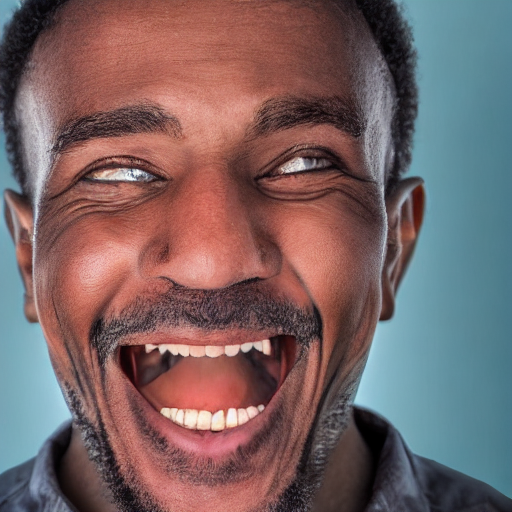

In [55]:
for ima in image_list:
    display(ima)

-----
-----
### Part 6 - Analyze endpoint logs <a name="logs"></a>

Let's analyze our endpoint's CloudWatch logs and verify the behaviour triggered by MME: as the GPU ran out of memory space, the first models we invoked are unloaded to make room for the ones invoked later. MME follows a Least Recently Used (LRU) policy to evict models from GPU memory or RAM (in the case of MME on CPU).

First we build the URL where we can access our endpoint's logs.

In [ ]:
cloudwatch_log_url = f'https://{region}.console.aws.amazon.com/cloudwatch/home?region={region}#logStream:group=/aws/sagemaker/Endpoints/{endpoint_name}'

print('âââClick the following link to access the endpoint logsâââ\n')
print(cloudwatch_log_url)

You then click on the logstream available under the link. Looking through the logs, you will be able to spot model unloads by the log message `Unloading SageMaker TargetModel:`.

----
----
### Part 7 - Clean up <a name="cleanup"></a>

In [ ]:
sm_client.delete_endpoint(EndpointName=endpoint_name)
sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
sm_client.delete_model(ModelName=sm_model_name)